# SENTIMENTAL ANALYSIS ON MAJOR ANTI-HYPERTENNSIVE DRUGS

### Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#fe">Feature Engineering</a></li>
<li><a href="#conclusions">Summary</a></li>
</ul>
<a name = "intro"></a>

## 1. Introduction
### 1.1 Objective

The objective of this project is to carry out sentimental analysis on anti-hypernsive drugs in the united state, build a webapp that either reassure user of these drug if negative sentiment are based on expected side effect or based on unexpected adverse effect as a result of inapproproate usage or combination with other drugs etc. Anti hypertensive drugs used are
- Amlodipine ```Brand names: Norvasc, Katerzia, Norliqva```
- Metoprolol ```Brand names: Metoprolol Succinate ER, Metoprolol Tartrate, Lopressor, Toprol-XL```
- Lisinopril ```Brand names: Zestril, Prinivil, Qbrelis``` 
- Losartan ```Brand names: Cozaar```
- Furosemide ```Brand names: Lasix, Diaqua-2, Lo-Aqua```


### 1.2 Data Source
- The data set used in notebook was scraped from 
    - https://www.drugs.com/
    - https://www.askapatient.com/
- Scraping script can be found here

In [1]:
#Import librarys
import pandas as pd
import re
import numpy as np
from PIL import Image
import nltk
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
%matplotlib inline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.filterwarnings('ignore')

## 2. Data Wrangling

In [3]:
# load both dataset
drugs = pd.read_csv('drugs.csv')
askAPatient = pd.read_csv('askapatient.csv')

### 2.1 Drugs
Data from https://www.drugs.com/

In [4]:
drugs.sample(5)

,drug,condition,review,rating
1367,Amlodipine,For High Blood Pressure:,“I switched to amlodipine after dry cough from...,1
371,Lisinopril,For Migraine Prevention:,“Since I started having slightly high blood pr...,10
1244,Amlodipine,For High Blood Pressure:,“I’ve been taking Amlodipine for a few weeks a...,3
1577,Amlodipine,For High Blood Pressure:,“I've been on amlodipine 5mg for high BP. Firs...,3
2372,Losartan,Cozaar (losartan) for High Blood Pressure:,“It is expensive but it's worth it to protect ...,9


In [5]:
#rows and columns
print('number of rows are:', drugs.shape[0]) 
print('number of columns are:', drugs.shape[1])

number of rows are: 2500
number of columns are: 4


In [6]:
#info
drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   drug       2500 non-null   object
 1   condition  2484 non-null   object
 2   review     2500 non-null   object
 3   rating     2500 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 78.2+ KB


In [7]:
#sum of nan by columns
drugs.isnull().sum()

drug          0
condition    16
review        0
rating        0
dtype: int64

- They are 16 Missing condition in the dataset. These will be left alone for now as our main concern is the review

In [8]:
drugs['rating'] =pd.cut(x=drugs['rating'], bins=[0, 3.0, 5.0, 7.0, 9.0, 10], labels=[1, 2, 3, 4, 5])

### 2.2 Askapatient
Data from https://www.askapatient.com/

In [9]:
askAPatient.sample(5)

,drug,condition,review,effect,rating
77,LISINOPRIL,High blood pressure,{'Comtrols my blood pressure'},"Short of breath, weak. Insomnia",3
954,NORVASC,High blod pressure,{'I am a pharmacist and I am reading this blog...,NaN,5
375,LISINOPRIL,Hypertension,{''},"Increased blood pressure, headaches, itchy eyes",1
1363,COZAAR,Hypertension,{'Talk to Dr. In Dec.about switching to someth...,"Light headied,sinusitis, sore back, shaky, hea...",2
1283,NORVASC,Blood Pressure control,"{""Had one long stent put in back about 3yrs ag...",Lower energy level,3


In [10]:
#rows and columns
print('number of rows are:', askAPatient.shape[0]) 
print('number of columns are:', askAPatient.shape[1])

number of rows are: 1780
number of columns are: 5


In [11]:
#info
askAPatient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   drug       1780 non-null   object
 1   condition  1744 non-null   object
 2   review     1780 non-null   object
 3   effect     1755 non-null   object
 4   rating     1780 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 69.7+ KB


In [12]:
#sum of nan by columns
askAPatient.isnull().sum()

drug          0
condition    36
review        0
effect       25
rating        0
dtype: int64

- They are 36 Missing condition and 25 missing side effect in the dataset. These will be left alone for now as our main concern is the review
- The side effect might not neccessarly be missing but rather none present or could have been inluded in the review

### 3.3 Main Dataframe

In [13]:
#concat both dataset
df = pd.concat([drugs, askAPatient], axis=0)

In [14]:
df.sample(5)

,drug,condition,review,rating,effect
2241,Losartan,For High Blood Pressure:,“Dr's have been trying to find the correct hyp...,4,NaN
918,Metoprolol,For Supraventricular Tachycardia:,“My heart rate was reaching 150 bpm just resti...,5,NaN
888,NORVASC,blood pressure,{''},1,It had my face very swollen. I was ugly I didn...
652,Metoprolol,For Supraventricular Tachycardia:,“I’ve had an extremely stressful year(s) - lik...,5,NaN
1709,Amlodipine,For High Blood Pressure:,“I'm a 58yr old Male with high blood pressure...,1,NaN


In [15]:
#reset index
df=df.reset_index(drop=True)

In [16]:
#rows and columns
print('number of rows are:', askAPatient.shape[0]) 
print('number of columns are:', askAPatient.shape[1])

number of rows are: 1780
number of columns are: 5


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   drug       4280 non-null   object
 1   condition  4228 non-null   object
 2   review     4280 non-null   object
 3   rating     4280 non-null   int64 
 4   effect     1755 non-null   object
dtypes: int64(1), object(4)
memory usage: 167.3+ KB


In [18]:
#checks for duplicate
print(f'{df.duplicated().sum()} duplicates in dataset')
df=df.drop(df[df.duplicated()].index, axis=0)# drp duplicated

240 duplicates in dataset


In [19]:
df.isnull().sum()

drug            0
condition      51
review          0
rating          0
effect       2398
dtype: int64

- The first data from drugs.com has no sideeffect columns concating both dataset result in 2398 nan for effect

In [20]:
#convert drugs to generic name
df['drug']=df['drug'].str.replace('M.*', 'Metoprolol', regex=True)
df['drug']=df['drug'].str.replace('LISIN.*', 'Lisinopril', regex=True)
df['drug']=df['drug'].str.replace('LAS.*', 'Furosemide', regex=True)
df['drug']=df['drug'].str.replace('CO.*', 'Losartan', regex=True)
df['drug']=df['drug'].str.replace('NORV.*', 'Amlodipine', regex=True)

### 3.4 NLP

In [21]:
#remove unwanted characters from review
df['review']=df['review'].str.strip('”')
df['review']=df['review'].str.strip('“')
df['review']=df['review'].str.replace('[{\'\'\"/\//}]', '', regex=True)
df['full_review'] = df['review'].copy()# copys review
df['review']=df['review'].str.lower()#converts to lower case

In [22]:
from contractions import expand_contractions
# Expanding Contractions in the reviews eg I'd've -----> I would have
df['review']=df['review'].apply(lambda x:expand_contractions(x))

In [23]:
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])
df['review'] = df['review'].apply(lambda x: remove_stopwords(x))

In [24]:
#remove number
df['review'] = df['review'].apply(lambda x: re.sub('\W*\d\w*','',x))

In [25]:
#remove unwanted characters from effect
df['effect']=df['effect'].fillna('{')
df['effect']=df['effect'].str.strip('”')
df['effect']=df['effect'].str.strip('“')
df['effect']=df['effect'].str.replace('[{\'\'\"}]', '', regex=True)
df['effect']=df['effect'].str.lower()#converts to lower case

In [26]:
#remove unwanted characters from condition
df['condition']=df['condition'].fillna('{')
df['condition']=df['condition'].str.strip('”')
df['condition']=df['condition'].str.strip('“')
df['condition']=df['condition'].str.replace('[{\'\'\":}]', '', regex=True)
#df['condition']=df['condition'].str.lower()#converts to lower case

## 3. Exploratory Data Analysis

In [27]:
allwords = ' '.join([review for review in df['review']])
print(f'Total number of character in corpous is {len(allwords)}')

Total number of character in corpous is 932629


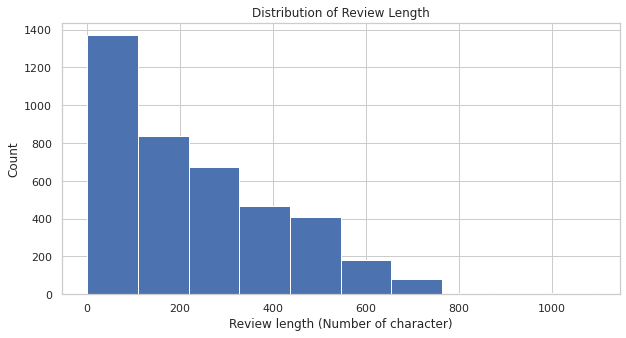

In [28]:
# Plot distribution of review length
review_length = df["review"].dropna().map(lambda x: len(x))
plt.figure(figsize=(10,5))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count');

- Number of most reviw character are between 0 t0 300

In [29]:
def lengtOfCharacter(text):
    length =len(text)
    return length
df['reviewLength']=df['review'].apply(lengtOfCharacter)
print(f"Longest review:\n\n {df['full_review'][df[df['reviewLength'] == df['reviewLength'].max()].index[0]]}")

Longest review:

 Had one long stent put in back about 3yrs ago. Was riding bike to work and had angina daily in the mornings during ride in but subsided. Was in denial for a week. Finally that Friday, had angina and took 2 aspirin, called GP Doc and talked to nurse. She said to immediately go to emerg rm. Rode bike to emerg. rm. EKG tests, and extensive testing done. Hosp really milking ins co at this point. Tuesday following week was getting stent put in, shocking....Was on Accupril 40mg, and Verelan. Had 1st encounter with Cardio Stent Doc. Stent was put in due to blockage-angina. Ins Co changed policy on paying for Verapimil, so asked Cardio Stent Doc. to pick an equivalent off Ins Co list. He picked 5 mg Norvasc. Was on 5 mg Norvasc for 3 yrs, no real problems except low physical energy. May 10,2005-had the radioacive dye test with treadmil for first time to see if heart muscle is getting good blood flow. New Cardio Doc. showed me pics and said 3 yrs ago when experiencing angina d

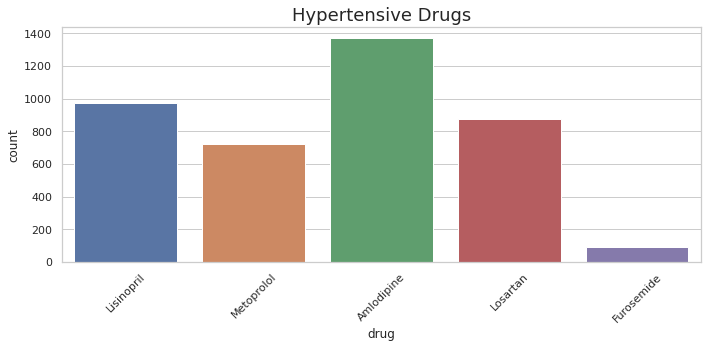

In [30]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='drug') # Count plot of gcs_cat column
plt.xticks(rotation=45)
plt.title('Hypertensive Drugs', fontsize=18)
plt.tight_layout()

- Amlodipine has the most review in the dataset while Furosemide occur the least

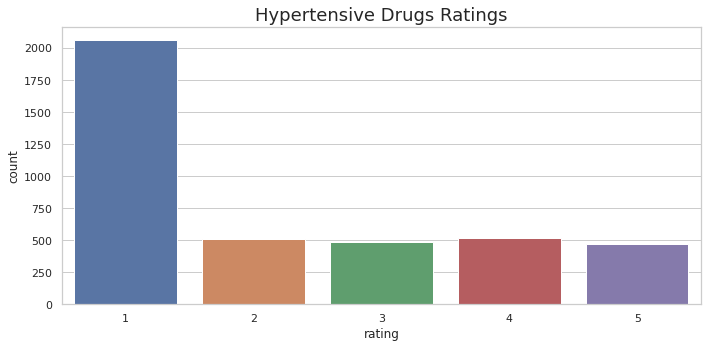

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='rating')
plt.title('Hypertensive Drugs Ratings', fontsize=18)
plt.tight_layout()

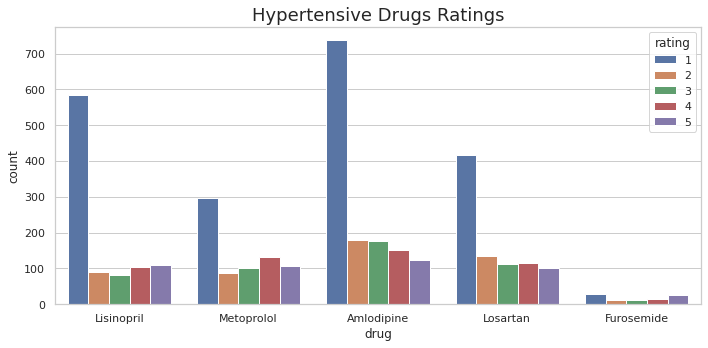

In [32]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='drug', hue='rating',) # Count plot of gcs_cat column
plt.title('Hypertensive Drugs Ratings',  fontsize=18)
plt.tight_layout()

In [33]:
drugs=list(df['drug'].value_counts()[:4].index)
drugs

['Amlodipine', 'Lisinopril', 'Losartan', 'Metoprolol']

Word Cloud:



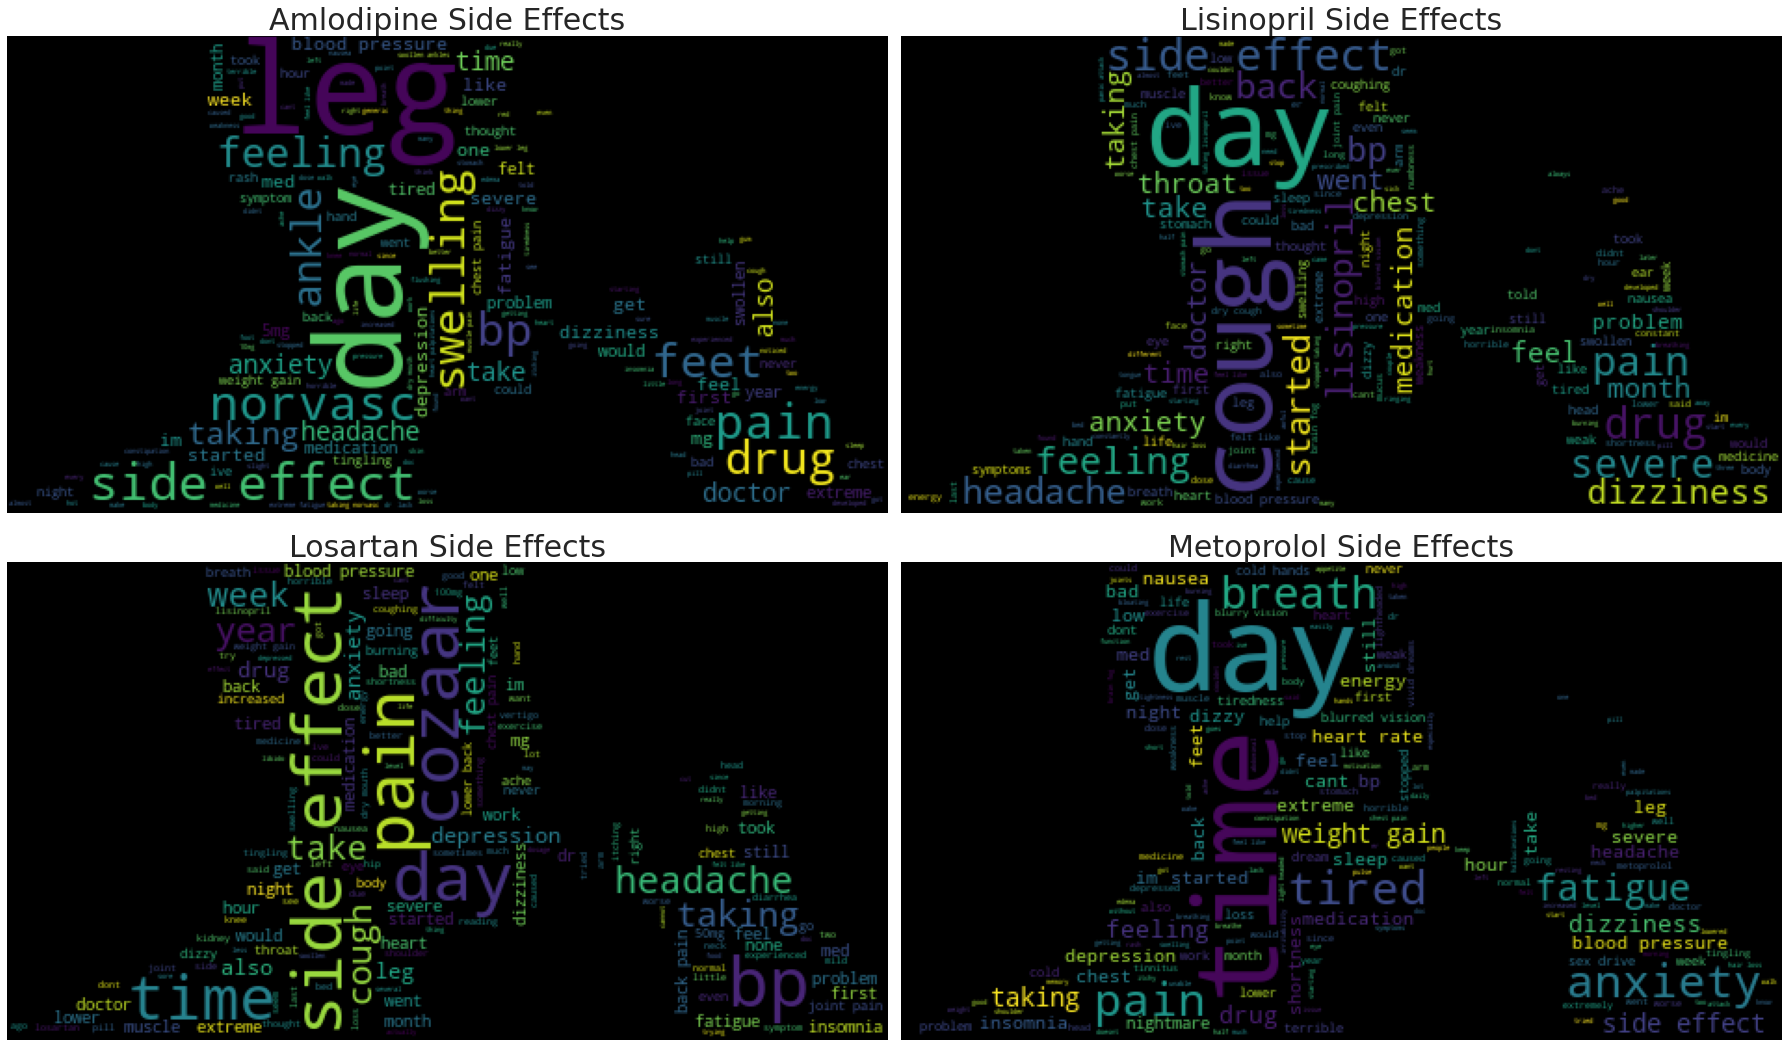

In [34]:
im = Image.open("dd2.png")
print('Word Cloud:\n')
fig = plt.figure(figsize=(25,15))
for  drug  in drugs:
    ax=plt.subplot(2, 2, drugs.index(drug)+1)
    x=df[df['drug'] == drug]
    allwords = ' '.join([review for review in x['effect']])
    bg_pic = np.asarray(im)
    wc = WordCloud(mask=bg_pic,stopwords=stop_words, background_color='black',margin=2).generate(allwords)
    ax.imshow(wc)
    plt.title(f'{drug} Side Effects', fontsize=30)
    ax.set_axis_off();
plt.tight_layout() 

Word Cloud:



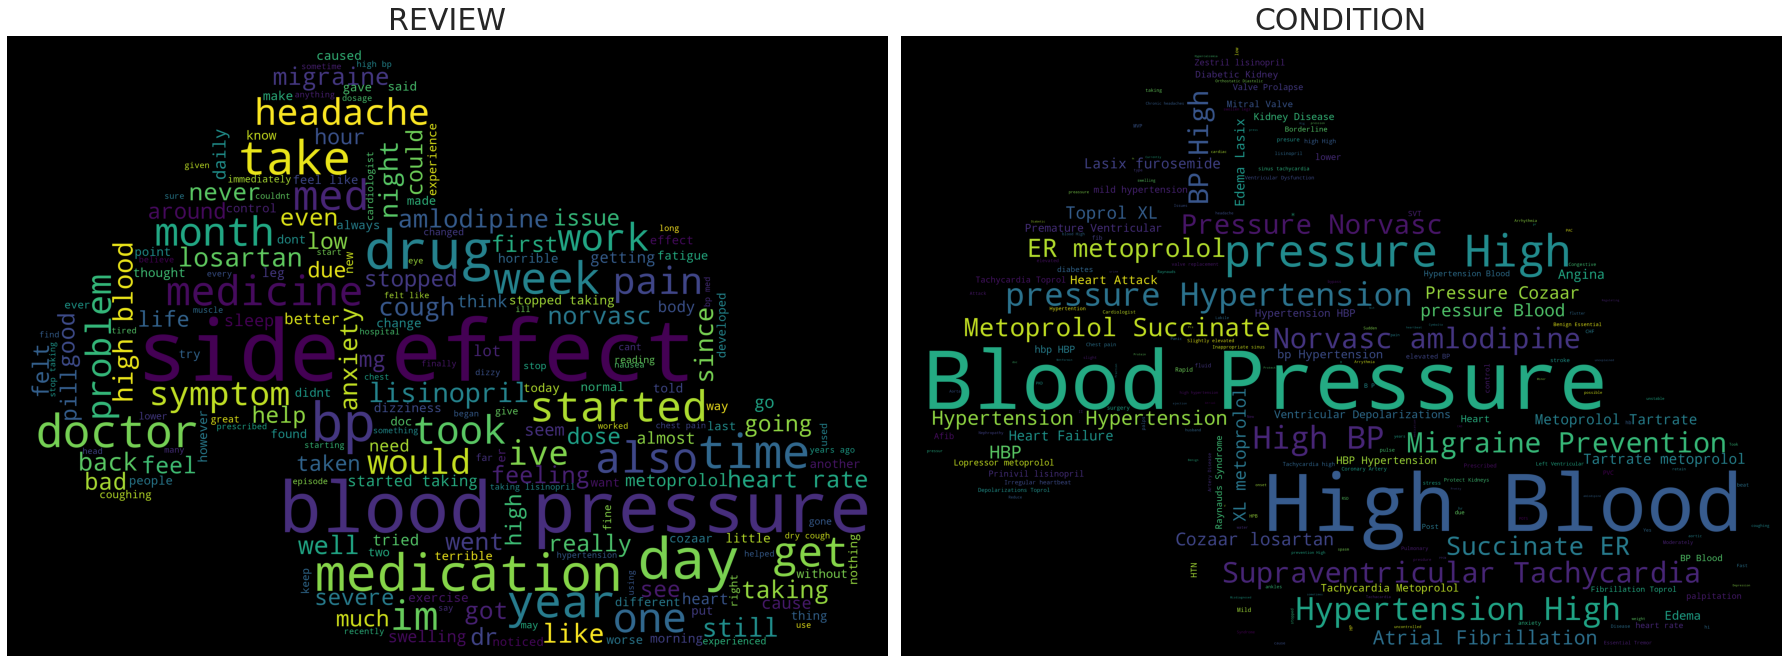

In [35]:
x=['review', 'condition']
im = Image.open("rr2.png")
print('Word Cloud:\n')
fig = plt.figure(figsize=(25,15))
for  i  in x:
    ax=plt.subplot(1, 2, x.index(i)+1)
    #x=df[df['drug'] == drug]
    allwords = ' '.join([review for review in df[i]])
    bg_pic = np.asarray(im)
    wc = WordCloud(mask=bg_pic,stopwords=stop_words, background_color='black',margin=2).generate(allwords)
    ax.imshow(wc)
    plt.title(f'{i.upper()}', fontsize=30)
    ax.set_axis_off();
plt.tight_layout() 

## 4. Sentimental Analysis

### 4.1 Sentiment Analysis with TextBlob

In [36]:
from textblob import TextBlob
def textBolbSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def textBolbPolarity(text):
    return TextBlob(text).sentiment.polarity

In [37]:
df['textBolbSubjectivity'] = df['review'].apply(textBolbSubjectivity)
df['textBolbPolarity'] = df['review'].apply(textBolbPolarity)

In [38]:
def sentiment(polarity):
#     if polarity == 0:
#         sentiment = 'Neutral'
    if polarity > 0:
        sentiment = 'Poitive'
    elif polarity <= 0:
        sentiment = 'Negative'
    return sentiment
df['textBolbSentiment'] = df['textBolbPolarity'].apply(sentiment)  

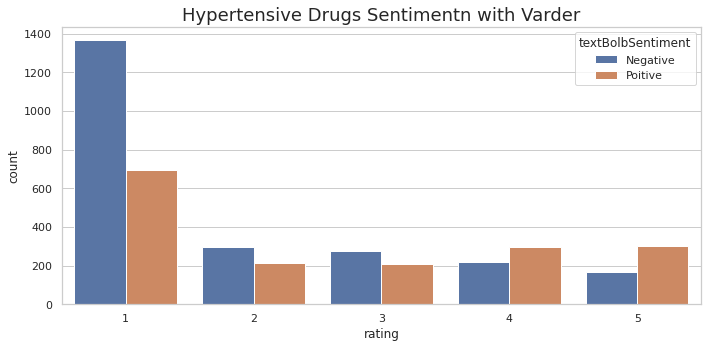

In [39]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='rating', hue='textBolbSentiment',) # Count plot of gcs_cat column
plt.title('Hypertensive Drugs Sentimentn with Varder',  fontsize=18)
plt.tight_layout()

In [55]:
df=df.drop(df[df['reviewLength']==0].index, axis=0)
df=df.reset_index(drop=True)
x=list(df.sample(5, random_state=12).index)

In [56]:
#evaluate
for i in x:
    print(f'{(x.index(i)+1)}, Drug: {df.iloc[i]["drug"]}')
    print(f'REVIEW: {df.iloc[i]["full_review"]}')
    print(f'TEXTBLOB SENTIMENT: {df.iloc[i]["textBolbSentiment"]}\n') 

1, Drug: Losartan
REVIEW: I do not recommend this drug to anyone.
TEXTBLOB SENTIMENT: Negative

2, Drug: Lisinopril
REVIEW: I am 27 years old and have been taking lisinopril for almost 2 years for high blood pressure, which also caused very frequent headaches. I was first prescribed 10 mg per day. I had a lot of light headedness and I actually fainted once. My cardiologist then lowered my dosage to 5 mg per day. My headaches are virtually gone. I havent had a true migraine since I started on the drug. I have woken twice with a swollen eye, which I didnt connect to lisinopril until I read the comments here, but other than that, Ive had zero side effects since switching to the 5 mg.
TEXTBLOB SENTIMENT: Poitive

3, Drug: Losartan
REVIEW: BP did not lower while taking Cozaar, it increased. Changed to Losartan (ARB) because ACE did not suit me and found it even worse.
TEXTBLOB SENTIMENT: Negative

4, Drug: Metoprolol
REVIEW: Metaprolol us a horrid drug.  I was started on 25mg 2x a day and o

### 4.2 Sentiment Analysis with Vader

In [57]:
#nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [58]:
#get polarity score
def vaderPolarity(text):
    x = sia.polarity_scores(text)
    return x['compound']
df['vaderPolarity'] = df['review'].apply(vaderPolarity)

In [59]:
#get sentiment
def sentiment(polarity):
    if polarity > 0:
        sentiment = 'Poitive'
    elif polarity <= 0:
        sentiment = 'Negative'
    return sentiment
df['vaderSentiment'] = df['vaderPolarity'].apply(sentiment)

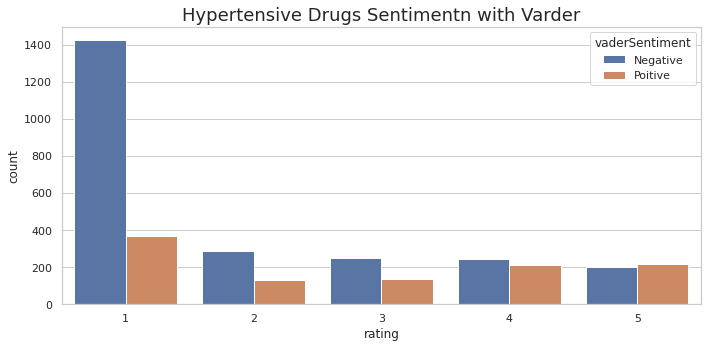

In [60]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='rating', hue='vaderSentiment',) # Count plot of gcs_cat column
plt.title('Hypertensive Drugs Sentimentn with Varder',  fontsize=18)
plt.tight_layout()

In [61]:
#evaluate
for i in x:
    print(f'{(x.index(i)+1)}, Drug: {df.iloc[i]["drug"]}')
    print(f'REVIEW: {df.iloc[i]["full_review"]}')
    print(f'TEXTBLOB SENTIMENT: {df.iloc[i]["textBolbSentiment"]}\n') 

1, Drug: Losartan
REVIEW: I do not recommend this drug to anyone.
TEXTBLOB SENTIMENT: Negative

2, Drug: Lisinopril
REVIEW: I am 27 years old and have been taking lisinopril for almost 2 years for high blood pressure, which also caused very frequent headaches. I was first prescribed 10 mg per day. I had a lot of light headedness and I actually fainted once. My cardiologist then lowered my dosage to 5 mg per day. My headaches are virtually gone. I havent had a true migraine since I started on the drug. I have woken twice with a swollen eye, which I didnt connect to lisinopril until I read the comments here, but other than that, Ive had zero side effects since switching to the 5 mg.
TEXTBLOB SENTIMENT: Poitive

3, Drug: Losartan
REVIEW: BP did not lower while taking Cozaar, it increased. Changed to Losartan (ARB) because ACE did not suit me and found it even worse.
TEXTBLOB SENTIMENT: Negative

4, Drug: Metoprolol
REVIEW: Metaprolol us a horrid drug.  I was started on 25mg 2x a day and o

### 4.3 Sentiment Analysis with Bert

In [2]:
#Import traansformer
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

2022-07-09 18:45:18.480625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-09 18:45:18.480900: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
2022-07-09 18:46:18.955391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-09 18:46:18.955435: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-09 18:46:18.955470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not 

In [7]:
from tqdm.notebook import tqdm_notebook for #progress bar
score = []
sentiment = []
for j, i in tqdm_notebook(df.iterrows()):
    try:
        sentiment.append(sentiment_pipeline(i['review'])[0]['label'])
        score.append(sentiment_pipeline(i['review'])[0]['score'])
    except ValueError:
        print(j)
        sentiment.append(np.nan)
        score.append(np.nan)

0it [00:00, ?it/s]

In [14]:
#score and sentiment table
bert=pd.DataFrame({
    'bertscore' : score,
    'bersentiment' : sentiment})

In [23]:
#concat sentiment and scorre to dataframe
df = df.reset_index(drop=True)
df=pd.concat([df, bert], axis = 1)

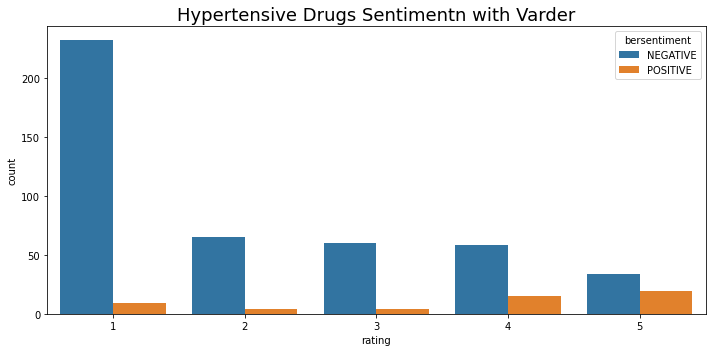

In [30]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='rating', hue='bersentiment',) # Count plot of gcs_cat column
plt.title('Hypertensive Drugs Sentimentn with Bert',  fontsize=18)
plt.tight_layout()

In [ ]:
#evaluate
for i in x:
    print(f'{(x.index(i)+1)}, Drug: {df.iloc[i]["drug"]}')
    print(f'REVIEW: {df.iloc[i]["full_review"]}')
    print(f'TEXTBLOB SENTIMENT: {df.iloc[i]["textBolbSentiment"]}\n') 